1. default model 5 month cv: 13.626843589225533
2. 9 lags cv: 13.53556931664027
3. 10 lags cv: 13.624367615821392
4. 40 lags cv: 13.64541997430164
5. large model cv: 13.579021071834704
6. bigger model: 13.665582202290945
7. 13.58226912560271

In [452]:
MODEL = 'ensemble' #lgb, xgb, cat, ensemble  
CV = True
LAGS = 30
SUB_PATH = None
OUT_PATH = 'final_submission.csv'

In [453]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap



In [454]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_census = pd.read_csv('data/census_starter.csv')
df_reveal = pd.read_csv('data/revealed_test.csv')
df_train = pd.concat([df_train,df_reveal],axis=0).sort_values(by=['cfips','first_day_of_month']).reset_index()
df_cfips_location = pd.read_csv('data/cfips_location.csv')
df_sub = pd.read_csv('data/sample_submission.csv')

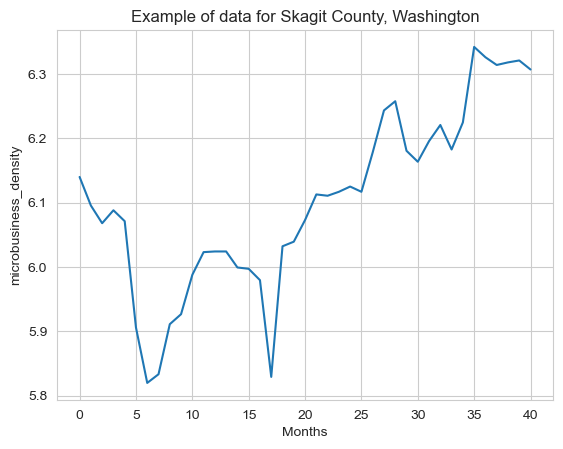

In [455]:
np.random.seed(42)
idx = np.random.randint(low=0,high=df_train.shape[0])
example_data = df_train[df_train.cfips == df_train.iloc[idx,:].cfips]
sns.lineplot(x=range(example_data.shape[0]),y=example_data.microbusiness_density)
plt.xlabel('Months')
plt.title('Example of data for {}, {}'.format(example_data.county.iloc[0],example_data.state.iloc[0]))
plt.savefig('imgs/example-data.pdf')

In [456]:
df_train.head()

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [457]:
df_train[df_train.active==df_train.active.min()]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
58484,55632,28055_2021-02-01,28055,Issaquena County,Mississippi,2021-02-01,0.0,0
58485,55633,28055_2021-03-01,28055,Issaquena County,Mississippi,2021-03-01,0.0,0
58486,55634,28055_2021-04-01,28055,Issaquena County,Mississippi,2021-04-01,0.0,0
58487,55635,28055_2021-05-01,28055,Issaquena County,Mississippi,2021-05-01,0.0,0
58488,55636,28055_2021-06-01,28055,Issaquena County,Mississippi,2021-06-01,0.0,0
58489,55637,28055_2021-07-01,28055,Issaquena County,Mississippi,2021-07-01,0.0,0
58490,55638,28055_2021-08-01,28055,Issaquena County,Mississippi,2021-08-01,0.0,0
58491,55639,28055_2021-09-01,28055,Issaquena County,Mississippi,2021-09-01,0.0,0
58492,55640,28055_2021-10-01,28055,Issaquena County,Mississippi,2021-10-01,0.0,0
58493,55641,28055_2021-11-01,28055,Issaquena County,Mississippi,2021-11-01,0.0,0


([<matplotlib.axis.XTick at 0x20f0ae29310>], [Text(41.0, 0, '')])

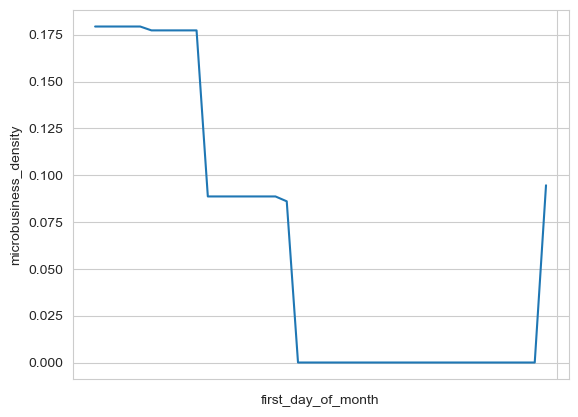

In [458]:
sns.lineplot(df_train[df_train.cfips==28055],x='first_day_of_month',y='microbusiness_density')
plt.xticks('')

In [459]:
df_train.active.astype(int).describe()

count    1.285350e+05
mean     6.461169e+03
std      3.311759e+04
min      0.000000e+00
25%      1.450000e+02
50%      4.900000e+02
75%      2.126500e+03
max      1.167744e+06
Name: active, dtype: float64

In [460]:
# train = pd.concat([df_train,df_reveal]).sort_values(by=['cfips','first_day_of_month'])
# train = train.merge(df_cfips_location.drop("name", axis=1), on="cfips")
# train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
# train
import os

train = df_train
test = df_test
drop_index = (test.first_day_of_month == '2022-11-01') | (test.first_day_of_month == '2022-12-01')
test = test.loc[~drop_index,:]

coords = df_cfips_location
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw = raw.merge(coords.drop("name", axis=1), on="cfips")

raw['state_i1'] = raw['state'].astype('category')
raw['county_i1'] = raw['county'].astype('category')
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['scale'] = (raw['first_day_of_month'] - raw['first_day_of_month'].min()).dt.days
raw['scale'] = raw['scale'].factorize()[0]
#raw['population'] = np.round(np.mean(raw['active']*100/raw['microbusiness_density']))

os.environ["CUDA_VISIBLE_DEVICES"]="0"
raw.head()

C:\Users\Wuy19\AppData\Local\Temp\ipykernel_14480\939728738.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['istest'] = 1


,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,lng,lat,state_i1,county_i1,dcount,county_i,state_i,scale
0,0.0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,-86.6429,32.535142,Alabama,Autauga County,0,0,0,0
1,1.0,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,-86.6429,32.535142,Alabama,Autauga County,1,0,0,1
2,2.0,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,-86.6429,32.535142,Alabama,Autauga County,2,0,0,2
3,3.0,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,-86.6429,32.535142,Alabama,Autauga County,3,0,0,3
4,4.0,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,-86.6429,32.535142,Alabama,Autauga County,4,0,0,4


<Axes: ylabel='microbusiness_density'>

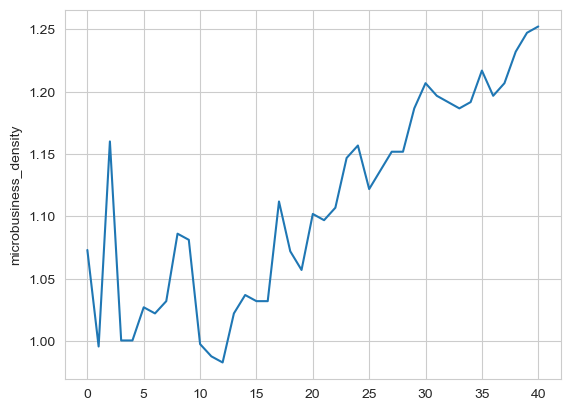

In [461]:
outlier_data = raw[raw.cfips==1005]
sns.lineplot(x=range(outlier_data.shape[0]), y=outlier_data['microbusiness_density'])

In [462]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    #vmax = np.max(var[:38]) - np.min(var[:38])
    
    for i in range(37, 2, -1):
        thr = 0.10 * np.mean(var[:i])
        dif = var[i]-var[i-1]
        if (dif>=thr) or (dif<=-thr):
            if dif > 0:
                var[:i] += dif - 3e-3
            else:
                var[:i] += dif + 3e-3
            outliers.append((o,i))
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var
    
# outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

(2367, 2367)

<Axes: ylabel='microbusiness_density'>

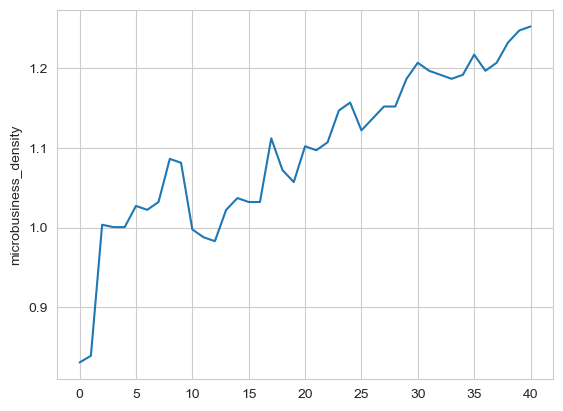

In [463]:
#1005,3 
outlier_data = raw[raw.cfips==1005]
sns.lineplot(x=range(outlier_data.shape[0]), y=outlier_data['microbusiness_density'])

In [464]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
# raw.groupby('dcount')['dif'].sum().plot()

In [465]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1


raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

# raw.iloc[:20,:20]

In [466]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

# dt = raw.loc[raw.dcount==40].groupby('cfips')['microbusiness_density'].agg('last')
# raw['lasttarget'] = raw['cfips'].map(dt)

# raw['lastactive'].clip(0, 8000).hist(bins=30)

In [467]:
def rebuild_lags(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
    return raw

In [468]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6, 8, 10]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
    
    census_columns = list(df_census.columns)
    census_columns.remove( "cfips")
    
    raw = raw.merge(df_census, on="cfips", how="left")
    feats += census_columns
    
    co_est = pd.read_csv("data/co-est2021-alldata.csv", encoding='latin-1')
    co_est["cfips"] = co_est.STATE*1000 + co_est.COUNTY
    co_columns = [
        'SUMLEV',
        'DIVISION',
        'ESTIMATESBASE2020',
        'POPESTIMATE2020',
        'POPESTIMATE2021',
        'NPOPCHG2020',
        'NPOPCHG2021',
        'BIRTHS2020',
        'BIRTHS2021',
        'DEATHS2020',
        'DEATHS2021',
        'NATURALCHG2020',
        'NATURALCHG2021',
        'INTERNATIONALMIG2020',
        'INTERNATIONALMIG2021',
        'DOMESTICMIG2020',
        'DOMESTICMIG2021',
        'NETMIG2020',
        'NETMIG2021',
        'RESIDUAL2020',
        'RESIDUAL2021',
        'GQESTIMATESBASE2020',
        'GQESTIMATES2020',
        'GQESTIMATES2021',
        'RBIRTH2021',
        'RDEATH2021',
        'RNATURALCHG2021',
        'RINTERNATIONALMIG2021',
        'RDOMESTICMIG2021',
        'RNETMIG2021'
    ]
    raw = raw.merge(co_est, on="cfips", how="left")
    feats +=  co_columns
    return raw, feats

In [469]:
raw, feats = build_features(raw, 'target', 'active', lags = LAGS)
features = ['state_i']
features += feats
features += ['lng','lat','scale']
coordinates = raw[['lng', 'lat']].values

# Encoding tricks
emb_size = 20
precision = 1e6

latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision)/emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1,1, emb_size)
latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])

In [470]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + \
                                (np.sin(np.radians(angle)) * df['lng'])
        
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - \
                                (np.sin(np.radians(angle)) * df['lng'])
        
    return df

raw = rot(raw)

In [471]:
features += ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y']

In [472]:
raw[features]

,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4,act_lag_4,mbd_lag_5,...,RNETMIG2021,lng,lat,scale,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.102668,-86.642900,32.535142,0,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
1,0,0.010101,-51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.102668,-86.642900,32.535142,1,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
2,0,0.059265,71.0,0.010101,20.0,NaN,NaN,NaN,NaN,NaN,...,4.102668,-86.642900,32.535142,2,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
3,0,-0.020489,-26.0,0.059265,45.0,0.010101,-6.0,NaN,NaN,NaN,...,4.102668,-86.642900,32.535142,3,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
4,0,0.000000,0.0,-0.020489,-26.0,0.059265,45.0,0.010101,-6.0,NaN,...,4.102668,-86.642900,32.535142,4,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,50,NaN,NaN,NaN,NaN,0.010000,NaN,0.000000,NaN,0.00,...,-3.984064,-104.567404,43.840315,42,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
147341,50,NaN,NaN,NaN,NaN,NaN,NaN,0.010000,NaN,0.00,...,-3.984064,-104.567404,43.840315,43,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
147342,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,...,-3.984064,-104.567404,43.840315,44,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
147343,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.984064,-104.567404,43.840315,45,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104


In [473]:
def get_model():
    from sklearn.ensemble import VotingRegressor,StackingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    
    cat_model = cat.CatBoostRegressor(
        iterations=400,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.2,
        subsample=0.70,
        max_bin=4096,
    )
    return cat_model

def base_models():
    from sklearn.ensemble import VotingRegressor
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    from sklearn.pipeline import Pipeline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.impute import KNNImputer    
    
    # LGBM model
    params = {
    'number_iterations': 400,
    'boosting_type': 'dart',
    'verbosity': -1,
    'objective': 'l1',
    'colsample_bytree': 0.8841279649367693,
    'colsample_bynode': 0.10142964450634374,
    'max_depth': 16,
    'learning_rate': 0.003647749926797374,
    'lambda_l2': 0.5,
    'num_leaves': 61,
    "seed": 512,
    }

    lgb_model = lgb.LGBMRegressor(**params)
    
    xgb_model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    tree_method="hist",
    n_estimators=795,
    learning_rate=0.0075,
    max_leaves = 32,
    subsample=0.50,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2)

    # we should decrease the num_iterations of catboost
    cat_model = cat.CatBoostRegressor(
        iterations=1200,
        loss_function="MAPE",
        verbose=0,
        grow_policy='SymmetricTree',
        learning_rate=0.035,
        colsample_bylevel=0.8,
        max_depth=5,
        l2_leaf_reg=0.4,
        subsample=0.70,
        max_bin=4096,
    )
    return xgb_model,lgb_model,cat_model

In [474]:
ACT_THR = 150
raw = raw.ffill()
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
raw['microbusiness_density'].fillna(0, inplace = True)
FIRST_MONTH = 39
LAST_MONTH = 40

In [475]:

if CV:
    ACT_THR = 150
    raw['ypred_last'] = np.nan
    raw['ypred'] = np.nan
    raw['k'] = 1.
    raw['microbusiness_density'].fillna(0, inplace = True)
    FIRST_MONTH = 35
    raw[raw.dcount < FIRST_MONTH].istest = 1
    LAST_MONTH = 40
    CLIPS = [-2e-3,6e-3]
    TS = FIRST_MONTH
    print(f'TS: {TS}')

    # model = get_model()
    # raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
    # raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115 
    # & (raw.lastactive>ACT_THR) & (raw.cfips!=28055) & (raw.cfips!=48269)
    model0,model1,model2 = base_models()       
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) 

    if MODEL != 'ensemble':
        if MODEL == 'lgb':
            model = model1
        elif MODEL == 'xgb':
            model = model0
        else:
            model = model2
        model.fit(
            raw.loc[train_indices, features],
            raw.loc[train_indices, 'target'].clip(*CLIPS),)
    else:
        # Train each of the models on the current TS
        model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(*CLIPS),)

        model1.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(*CLIPS),)

        model2.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(*CLIPS),)


        tr_pred0 = model0.predict(raw.loc[train_indices, features])
        tr_pred1 = model1.predict(raw.loc[train_indices, features])
        tr_pred2 = model2.predict(raw.loc[train_indices, features])
        train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))

        meta_model = get_model() 
        meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(*CLIPS),)
        

C:\Users\Wuy19\AppData\Local\Temp\ipykernel_14480\2250900633.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw[raw.dcount < FIRST_MONTH].istest = 1


TS: 35
[LightGBM] [Warning] Unknown parameter: number_iterations
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [476]:
if CV:
    ## Validate
    scores = 0
    ys = []
    gt = []
    for TS in range(FIRST_MONTH,LAST_MONTH):
        
        valid_indices = (raw.istest==0) & (raw.dcount == TS) 
        gt.append(raw.loc[valid_indices][['cfips','microbusiness_density']].copy())
        if MODEL != 'ensemble':
            ypred = model.predict(raw.loc[valid_indices, features])
        else:
            val_preds0 = model0.predict(raw.loc[valid_indices, features])
            val_preds1 = model1.predict(raw.loc[valid_indices, features])
            val_preds2 = model2.predict(raw.loc[valid_indices, features])
            valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))

            ypred = meta_model.predict(valid_preds)
        raw.loc[valid_indices, 'k'] = ypred + 1
        raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

        lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
        dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

        df = raw.loc[raw.dcount==TS+1, 
                    ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
        df['pred'] = df['cfips'].map(dt)
        df['lastval'] = df['cfips'].map(lastval)

        df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']

        raw.loc[raw.dcount==TS+1, 'ypred'] = df['pred'].values
        raw.loc[raw.dcount==TS+1, 'ypred_last'] = df['lastval'].values
        # raw.loc[raw.dcount==TS+1, 'microbusiness_density'] = raw.loc[raw.dcount==TS+1, 'ypred']

        print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
        print('SMAPE:', smape(df['microbusiness_density'], df['pred']))
        scores += smape(df['microbusiness_density'], df['pred'])
        ys.append(df[['cfips','pred']].copy())
    print('5 months cv score',scores/(LAST_MONTH-FIRST_MONTH))

c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Last Value SMAPE: 1.186273598907702
SMAPE: 1.4990993715278516
Last Value SMAPE: 0.9685083234127587
SMAPE: 0.9870955804065034
Last Value SMAPE: 1.101119095956366
SMAPE: 1.1207769377969543
Last Value SMAPE: 1.0936951422059114
SMAPE: 1.1992233901293607
Last Value SMAPE: 1.889206717018118
SMAPE: 1.8756018480584273
5 months cv score 1.3363594255838194


c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Wuy19\.conda\envs\torch\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


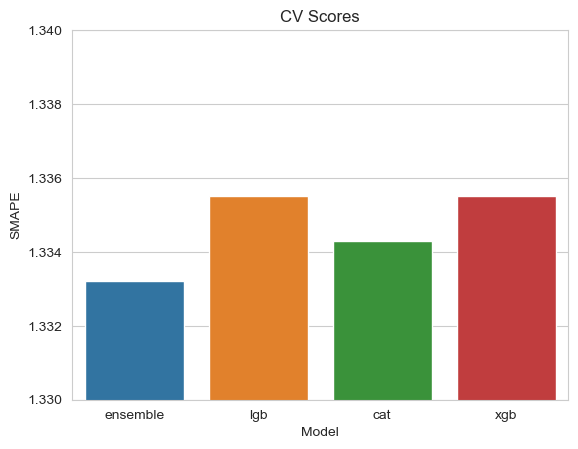

In [477]:
ensemble_cv = 1.3332
lgb_cv = 1.3355
cat_cv = 1.3343
xgb_cv = 1.3355
# visualize and set bigger font
sns.set_style('whitegrid')
sns.barplot(x=['ensemble','lgb','cat','xgb'], y=[ensemble_cv,lgb_cv,cat_cv,xgb_cv],)
plt.ylim(1.33,1.34)
plt.title('CV Scores')
plt.xlabel('Model')
plt.ylabel('SMAPE')
plt.savefig('imgs/cv_scores.pdf')
plt.show()

ensemble 5 months cv score 1.3332

lGBM 5 months cv score 1.335502674450289

Cat 5 months cv score 1.3343968368768722

XGB 5 months 1.2449

AssertionError: 

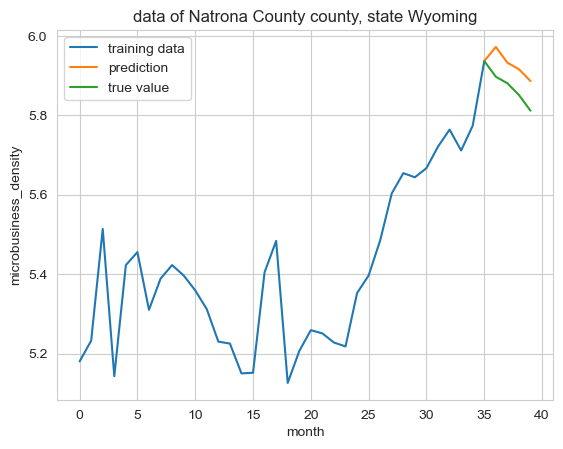

In [478]:
import random
random.seed(42)
if CV:
    idx = np.random.randint(low=0,high=raw.shape[0])
    example_data = raw[raw.cfips == raw.iloc[idx,:].cfips]
    # train_data
    train_seg = example_data[example_data.dcount<=FIRST_MONTH]
    sns.lineplot(x=range(train_seg.shape[0]),y=train_seg.microbusiness_density,label='training data')
    # pred
    test_seg = np.concatenate([[train_seg.microbusiness_density.values[-1]]]+[y[y.cfips == raw.iloc[idx,:].cfips].pred.values for y in ys])
    sns.lineplot(x=range(FIRST_MONTH,LAST_MONTH),y = test_seg[:-1], label='prediction')
    # gt
    test_seg = np.concatenate([y[y.cfips == raw.iloc[idx,:].cfips].microbusiness_density.values for y in gt])
    sns.lineplot(x=range(FIRST_MONTH,LAST_MONTH),y=test_seg, label='true value')
    plt.xlabel('month')
    plt.title('data of {} county, state {}'.format(raw.iloc[idx,:].county, raw.iloc[idx,:].state))
    plt.savefig('imgs/visualize.pdf')
    assert False


In [ ]:
if CV:
    assert False

In [ ]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('data/ACSST5Y2020.S0101-Data.csv', usecols=COLS, dtype = 'object')
df2021 = pd.read_csv('data/ACSST5Y2021.S0101-Data.csv',usecols=COLS, dtype = 'object')

df2020 = df2020.iloc[1:]
df2020 = df2020.astype({'S0101_C01_026E':'int'})

df2021 = df2021.iloc[1:]
df2021 = df2021.astype({'S0101_C01_026E':'int'})

df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

df2020['mnoshitel'] = df2020['S0101_C01_026E'] / df2021['S0101_C01_026E']

df2020 = df2020[['cfips','mnoshitel']]
df2020.set_index('cfips', inplace=True)

raw = raw.join(df2020, on='cfips')


In [ ]:
TS = 40
print(TS)

model0,model1,model2 = base_models()
CLIPS = [-2e-3,6e-3]
train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) 
valid_indices = (raw.dcount == TS)

model0.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(*CLIPS))
    
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(*CLIPS))

model2.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(*CLIPS))


tr_pred0 = model0.predict(raw.loc[train_indices, features])
tr_pred1 = model1.predict(raw.loc[train_indices, features])
tr_pred2 = model2.predict(raw.loc[train_indices, features])
train_preds = np.column_stack((tr_pred0, tr_pred1, tr_pred2))

meta_model = get_model() 
meta_model.fit(train_preds, raw.loc[train_indices, 'target'].clip(*CLIPS))

val_preds0 = model0.predict(raw.loc[valid_indices, features])
val_preds1 = model1.predict(raw.loc[valid_indices, features])
val_preds2 = model2.predict(raw.loc[valid_indices, features])
valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))

ypred = meta_model.predict(valid_preds)

40


/Users/wu/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[LightGBM] [Warning] Unknown parameter: number_iterations
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


In [ ]:
# baseline = pd.read_csv('sub/13724.csv')
if SUB_PATH:
    baseline = pd.read_csv(SUB_PATH)
    raw.loc[raw.dcount==41,'microbusiness_density'] = baseline[baseline.row_id.str.contains('2023-01-01')].microbusiness_density.values

In [ ]:
# Prediction
# raw['active'] = raw.groupby('cfips')['active'].ffill()
factors = []
for TS in tqdm(range(41 if SUB_PATH is not None else 40,raw.dcount.max()+1)):
    
    valid_indices = (raw.dcount == TS)
    val_preds0 = model0.predict(raw.loc[valid_indices, features])
    val_preds1 = model1.predict(raw.loc[valid_indices, features])
    val_preds2 = model2.predict(raw.loc[valid_indices, features])

    valid_preds = np.column_stack((val_preds0, val_preds1, val_preds2))

    ypred = meta_model.predict(valid_preds)
    factors.append(ypred)

    raw.loc[valid_indices, 'k'] = ypred + 1.0
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']
    next_indices = (raw.dcount == TS + 1)
    if TS + 1 <= raw.dcount.max():
        lastval = raw.loc[valid_indices, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
        dt = raw.loc[valid_indices, ['cfips', 'k']].set_index('cfips').to_dict()['k']
        df = raw.loc[next_indices, ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True).copy()

        df['pred'] = df['cfips'].map(dt)
        df['lastval'] = df['cfips'].map(lastval)

        # use last value to underfit low active value
        df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']

        raw.loc[next_indices, 'ypred'] = df['pred'].values
        raw.loc[next_indices, 'ypred_last'] = df['lastval'].values

        raw.loc[next_indices].loc[raw['cfips']==28055, 'microbusiness_density'] = 0
        raw.loc[next_indices].loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115 
        if TS==40:
            raw.loc[next_indices, 'microbusiness_density'] = raw.loc[next_indices, 'ypred'] * raw.loc[next_indices, 'mnoshitel']
        else:
            raw.loc[next_indices, 'microbusiness_density'] = raw.loc[next_indices, 'ypred']
        #  * raw.loc[next_indices, 'mnoshitel']
        
        # rounding to the nearest integer
        raw['adult2021'] = raw['cfips'].map(adult2021)
        raw.loc[next_indices,'microbusiness_density'] = (
            np.round(raw.loc[next_indices,'microbusiness_density'] * raw['adult2021'] / 100) / raw['adult2021'] * 100
        )
for TS in range(40,raw.dcount.max()):
    valid_indices = (raw.dcount == TS)
    next_indices = (raw.dcount == TS+1)
    delta = raw.loc[next_indices,'microbusiness_density'].values - raw.loc[valid_indices,'microbusiness_density'].values
    print(delta.mean(),delta.std(),smape(raw.loc[next_indices,'microbusiness_density'].values,raw.loc[valid_indices,'microbusiness_density'].values))
        # assert delta.std() <= 10
# prediction
# lastval = raw.loc[valid_indices, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
# dt = raw.loc[valid_indices, ['cfips', 'k']].set_index('cfips').to_dict()['k']
test = raw.loc[raw.first_day_of_month >= '2022-11-01', ['row_id', 'microbusiness_density']].copy()
baseline = pd.read_csv('sub/13724.csv')
print(smape(test[test.row_id.str.contains('2023-01-01')].microbusiness_density.values,baseline[baseline.row_id.str.contains('2023-01-01')].microbusiness_density.values))

  0%|          | 0/7 [00:00<?, ?it/s]

0.0035931023233457707 0.29761592975828355 2.674345013990818
0.013479847679118272 0.032660835726972044 0.27789974965568126
0.012682350888627314 0.03196202323929577 0.2653920379589718
0.010244281780869568 0.030913369847062156 0.22031179524554978
0.0118981538682705 0.031968835580573084 0.25190475910828136
0.013531780499842584 0.03299797414408665 0.281563187810966
0.0865951670465013


In [ ]:
test = raw.loc[raw.first_day_of_month >= '2022-11-01', ['row_id', 'microbusiness_density']].copy()
test
test.to_csv(OUT_PATH, index=False)

In [ ]:
baseline = pd.read_csv('data/best_score_13724.csv')
smape(test[test.row_id.str.contains('2023-01-01')].microbusiness_density.values,baseline[baseline.row_id.str.contains('2023-01-01')].microbusiness_density.values)

0.09336770955819229

13281


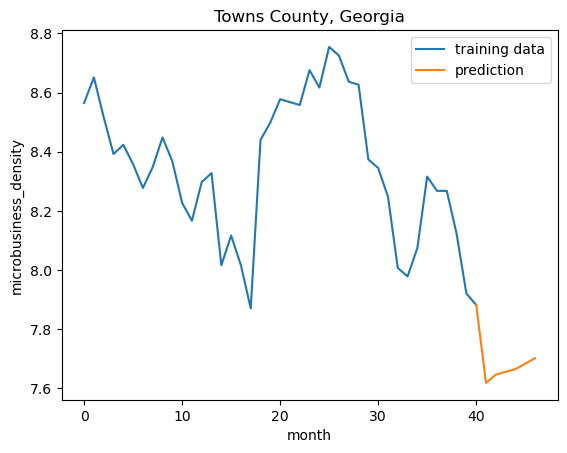

In [ ]:
idx = np.random.randint(low=0,high=raw.shape[0])
example_data = raw[raw.cfips == raw.iloc[idx,:].cfips]
train_seg = example_data[example_data.dcount<=40]
test_seg = example_data[(example_data.dcount>=40)]
sns.lineplot(x=range(train_seg.shape[0]),y=train_seg.microbusiness_density,label='training data')
sns.lineplot(x=range(train_seg.shape[0]-1,example_data.shape[0]),y=test_seg.microbusiness_density,label='prediction')
plt.xlabel('month')
plt.title(example_data.iloc[0].county+', '+example_data.iloc[0].state)
print(raw.iloc[idx,:].cfips)

In [ ]:
assert False

AssertionError: 

In [ ]:
raw.loc[valid_indices, ['cfips', 'microbusiness_density','k']].set_index('cfips')

,microbusiness_density,k
cfips,,
1001,3.470915,3.489242
1001,3.336757,0.000000
1001,0.000000,0.000000
1001,0.000000,0.000000
1001,0.000000,0.000000
...,...,...
56045,0.000000,0.000000
56045,0.000000,0.000000
56045,0.000000,0.000000


In [ ]:
# Assign prediction values

df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)

df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

# use last value to underfit low active value
df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']

raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values

In [ ]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==41, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test

,row_id,cfips,microbusiness_density
41,1001_2023-01-01,1001,0.0
42,1001_2023-02-01,1001,0.0
43,1001_2023-03-01,1001,0.0
44,1001_2023-04-01,1001,0.0
45,1001_2023-05-01,1001,0.0
...,...,...,...
147340,56045_2023-02-01,56045,0.0
147341,56045_2023-03-01,56045,0.0
147342,56045_2023-04-01,56045,0.0
147343,56045_2023-05-01,56045,0.0


In [ ]:
COLS = ['GEO_ID','NAME','S0101_C01_026E']
df2020 = pd.read_csv('data/ACSST5Y2020.S0101-Data.csv', usecols=COLS, dtype = 'object')
df2021 = pd.read_csv('data/ACSST5Y2021.S0101-Data.csv',usecols=COLS, dtype = 'object')

df2020 = df2020.iloc[1:]
df2020 = df2020.astype({'S0101_C01_026E':'int'})

df2021 = df2021.iloc[1:]
df2021 = df2021.astype({'S0101_C01_026E':'int'})

df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

df2020['mnoshitel'] = df2020['S0101_C01_026E'] / df2021['S0101_C01_026E']

df2020 = df2020[['cfips','mnoshitel']]
df2020.set_index('cfips', inplace=True)

In [ ]:
raw = raw.join(df2020, on='cfips')
maska = (raw["first_day_of_month"]=='2023-01-01')
raw.loc[maska, 'microbusiness_density'] = raw.loc[maska, 'ypred'] * raw.loc[maska, 'mnoshitel']
raw.drop(columns = 'mnoshitel' , inplace = True)

In [ ]:
test = raw[raw.first_day_of_month >= '2022-11-01'].copy()
test = test[['row_id', 'cfips', 'microbusiness_density']]
test = test[['row_id', 'microbusiness_density']]
test.to_csv('em_submission.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

# submission from
submission = pd.read_csv('em_submission.csv')
submission['cfips'] = submission['row_id'].map(lambda x: int(x.split('_')[0]))

# get adult_population
column_names = ['GEO_ID','NAME','S0101_C01_026E']
df2021 = pd.read_csv('data/ACSST5Y2021.S0101-Data.csv', usecols=column_names)
df2021 = df2021.iloc[1:]
df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]))
adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

submission['adult2021'] = submission['cfips'].map(adult2021)

# rounding to the nearest integer
submission['microbusiness_density'] = (
    np.round(submission['microbusiness_density'] * submission['adult2021'] / 100) / submission['adult2021'] * 100
)

submission[['row_id', 'microbusiness_density']].to_csv('round_submission.csv', index=False)

/var/folders/y4/9bc9208j79x5x1q7xs1g71kc0000gn/T/ipykernel_32862/3939351510.py:10: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv('data/ACSST5Y2021.S0101-Data.csv', usecols=column_names)


In [ ]:
submission[submission.cfips==1001]

,row_id,microbusiness_density,cfips,adult2021
0,1001_2022-11-01,3.442999,1001,44438
1,1001_2022-12-01,3.470003,1001,44438
2,1001_2023-01-01,3.337234,1001,44438
3,1001_2023-02-01,0.000000,1001,44438
4,1001_2023-03-01,0.000000,1001,44438
5,1001_2023-04-01,0.000000,1001,44438
6,1001_2023-05-01,0.000000,1001,44438
7,1001_2023-06-01,0.000000,1001,44438


In [ ]:
raw[raw.istest==1].first_day_of_month.unique()

array(['2023-01-01T00:00:00.000000000', '2023-02-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
example_data.iloc[-10:,:]

,index,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
9789,9313,6109_2022-03-01,6109,Tuolumne County,California,2022-03-01,6.875401,3105
9790,9314,6109_2022-04-01,6109,Tuolumne County,California,2022-04-01,6.961759,3144
9791,9315,6109_2022-05-01,6109,Tuolumne County,California,2022-05-01,6.937402,3133
9792,9316,6109_2022-06-01,6109,Tuolumne County,California,2022-06-01,6.959545,3143
9793,9317,6109_2022-07-01,6109,Tuolumne County,California,2022-07-01,6.970616,3148
9794,9318,6109_2022-08-01,6109,Tuolumne County,California,2022-08-01,7.070260,3193
9795,9319,6109_2022-09-01,6109,Tuolumne County,California,2022-09-01,7.056974,3187
9796,9320,6109_2022-10-01,6109,Tuolumne County,California,2022-10-01,7.079117,3197
9797,476,6109_2022-11-01,6109,Tuolumne County,California,2022-11-01,7.028188,3174
9798,477,6109_2022-12-01,6109,Tuolumne County,California,2022-12-01,7.134474,3222


In [ ]:
idx = np.random.randint(low=0,high=raw.shape[0])
example_data = raw[raw.cfips == raw.iloc[idx,:].cfips]
sns.lineplot(x=range(example_data.shape[0]),y=example_data.microbusiness_density)

NameError: name 'np' is not defined